<a href="https://colab.research.google.com/github/uteyechea/crime-prediction-using-artificial-intelligence/blob/master/Part4_RNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 4 Recurrent Neural Net model
Define, train and generate crime predictions.

##4.1 Dependencies, mount Google Drive and set system path
Import the relevant packages we will use to train the RNN model.

In [1]:
# Import Tensorflow 2.0
%tensorflow_version 2.x
import tensorflow as tf 

#Mount my Google Drive 

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

#Define global path to working directory
path='/content/drive/My Drive/Colab Notebooks/crime_prediction'

#Update our path to import from 
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/crime_prediction/libs/')
import util

# Import all remaining packages
import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
import regex as re
import random

# Check that we are using a GPU, if not switch runtime
assert len(tf.config.list_physical_devices('GPU')) > 0
print(tf.config.list_physical_devices('GPU'))

Go to this URL in a browser:
Enter your authorization code:
··········
Mounted at /content/drive
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


##4.2 Import training file data

Load file contents to memory

In [2]:
def load_training_data(file_path):
    with open(file_path, "r") as f:
        text = f.read()
    windows = extract_windows(text)
    return windows

def extract_windows(text):
    pattern = '\n\n(.*?)\n\n'
    search_results = re.findall(pattern, text, overlapped=True, flags=re.DOTALL)
    windows = [window for window in search_results]
    print("Found {} autocorrelated windows in text".format(len(windows)))
    return windows

file_path=os.path.join(path,'data','training','theft.csv')
windows=load_training_data(file_path)

# Print one of the songs to inspect it in greater detail!
random_window=random.randint(0,len(windows))
example_window = windows[random_window]
print("Example: window {}".format(random_window))
print(example_window)

Found 43 autocorrelated windows in text
Example: window 12
0.643
0.321
0.607
0.143
0.321
0.571
0.357
0.357
0.357
0.536
0.536
0.714
0.500
0.500
0.536
0.607
0.250
0.500
0.643


Join all data in a single data memory location, then create a vocabulary of all unique symbols in the data.

In [3]:
# Join our list of windows into a single data string containing all windows
windows_joined='\n\n'.join(windows)
#print(windows_joined)
# Find all unique characters in the joined data string
vocabulary = sorted(set(windows_joined))
print('There are {} unique characters in the dataset'.format(len(vocabulary)))
print(vocabulary)

There are 12 unique characters in the dataset
['\n', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


## 4.3 Process the dataset for the learning task

Let's take a step back and consider our prediction task. We're trying to train a RNN model to learn patterns in crime, and then use this model to generate (i.e., predict) the expected crime locations and times.

The prediction task is all about given a character, or a sequence of characters, what is the most probable next character? 

Training the RNN consiste of feeding it an input made of a sequence of characters, so that the model learns to predict the output, i.e. the most likely character at each time step. 

RNNs maintain an internal state that remember all characters seen up until a given moment thus all history will be taken into account in generating a prediction sequence or character.

### 4.3.1 Vectorize the text

In order to make a general AI algortithm, that is one that is able to predict, text, numbers or symbols as in music, it is common practice to map all characters in the training data to a set of integers. Why? I need to learn more to answer this question. 
https://www.tensorflow.org/tutorials/text/text_generation
But i can say that for sure, this mapping allows the RNN to learn the appropiate data format, for example: n columns of numbers or words then a new line, wher n could be anything from a random number to a fixed number. 



So the usual way to proceed is as follows,
we will we'll generate two lookup tables: one that maps characters to numbers, and a second that maps numbers back to characters, like a dictionary in the common sense. 

In [4]:
### Define numerical representation of text ###

# Create a mapping from character to unique index.
# For example, to get the index of the character "d", 
#   we can evaluate `char2idx["d"]`.  
char2idx = {u:i for i, u in enumerate(vocabulary)}

# Create a mapping from indices to characters. This is
#   the inverse of char2idx and allows us to convert back
#   from unique index to the character in our vocabulary.
idx2char = np.array(vocabulary)

This gives us an integer representation for each character. Observe that the unique characters (i.e., our vocabulary) in the text are mapped as indices from 0 to `len(unique)`. Let's take a peek at this numerical representation of our dataset:

In [5]:
print('{')
for char,_ in zip(char2idx, range(len(vocabulary))):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  '.' :   1,
  '0' :   2,
  '1' :   3,
  '2' :   4,
  '3' :   5,
  '4' :   6,
  '5' :   7,
  '6' :   8,
  '7' :   9,
  '8' :  10,
  '9' :  11,
  ...
}


In [6]:
### Vectorize the criminal data string ###
def vectorize_string(string):
  vectorized_output = np.array([char2idx[char] for char in string])
  return vectorized_output

vectorized_windows = vectorize_string(windows_joined)
print('All autocorrelated crime data windows add up to {} integer numeric characters'.format(len(vectorized_windows)))

All autocorrelated crime data windows add up to 4943 integer numeric characters


We can also look at how the first part of the text is mapped to an integer representation:

In [7]:
print ('{} ---- characters mapped to int ----> {}'.format(repr(windows_joined[:10]), vectorized_windows[:10]))
# check that vectorized_songs is a numpy array
assert isinstance(vectorized_windows, np.ndarray), "returned result should be a numpy array"

'0.536\n0.46' ---- characters mapped to int ----> [2 1 7 5 8 0 2 1 6 8]


### 4.3.2 Create training examples and targets

Our next step is to actually divide the text into example sequences that we'll use during training. 

Each input sequence that we feed into our RNN will contain `seq_length` characters from the text.

We'll also need to define a target sequence for each input sequence, which will be used in training the RNN to predict the next character. 

For each input, the corresponding target will contain the same length of text, except shifted one character to the right.

To do this, we'll break the text into chunks of `seq_length+1`. Suppose `seq_length` is 4 and our text is "Hello". Then, our input sequence is "Hell" and the target sequence is "ello".

The batch method will then let us convert this stream of character indices to sequences of the desired size.

In [8]:
### Batch definition to create training examples ###

def get_batch(vectorized_windows, seq_length, batch_size):
  # the length of the vectorized songs string
  n = vectorized_windows.shape[0] - 1
  # randomly choose the starting indices for the examples in the training batch
  idx = np.random.choice(n-seq_length, batch_size)

  '''TODO: construct a list of input sequences for the training batch'''
  input_batch = [vectorized_windows[i : i+seq_length] for i in idx]
  # input_batch = # TODO
  '''TODO: construct a list of output sequences for the training batch'''
  target_batch = [vectorized_windows[i+1 : i+seq_length+1] for i in idx]
  # output_batch = # TODO

  # x_batch, y_batch provide the true inputs and targets for network training
  x_batch = np.reshape(input_batch, [batch_size, seq_length])
  y_batch = np.reshape(target_batch, [batch_size, seq_length])
  return x_batch, y_batch

For each of these vectors, each index is processed at a single time step. So, for the input at time step 0, the model receives the index for the first character in the sequence, and tries to predict the index of the next character. At the next timestep, it does the same thing, but the RNN considers the information from the previous step, i.e., its updated state, in addition to the current input.

We can make this concrete by taking a look at how this works over the first several characters in our text:

In [9]:
x_batch, y_batch = get_batch(vectorized_windows, seq_length=5, batch_size=1)

for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
    print("Step {:3d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step   0
  input: 8 ('6')
  expected output: 0 ('\n')
Step   1
  input: 0 ('\n')
  expected output: 2 ('0')
Step   2
  input: 2 ('0')
  expected output: 1 ('.')
Step   3
  input: 1 ('.')
  expected output: 4 ('2')
Step   4
  input: 4 ('2')
  expected output: 7 ('5')


## 4.4 The Recurrent Neural Network (RNN) model

The RNN model is based off the LSTM architecture, where we use a state vector to maintain information about the temporal relationships between consecutive characters. 

The final output of the LSTM is then fed into a fully connected [`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer where we'll output a softmax over each character in the vocabulary, and then sample from this distribution to predict the next character. 

To define the RNN model we will use the Keras API, specifically, [`tf.keras.Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential)

. L layers are used to define the model, where L is greater than or equal to 3. The three main layers are:

* [`tf.keras.layers.Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding): This is the input layer, consisting of a trainable lookup table that maps the numbers of each character to a vector with `embedding_dim` dimensions.
* [`tf.keras.layers.LSTM`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM): Our LSTM network, with size `units=rnn_units`. 
* [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): The output layer, with `vocab_size` outputs.

From here we will be upgrading the model with a stacked LSTM architecture. The number of LSTM layers will be a function of performance vs computing power required.


<img src="https://raw.githubusercontent.com/uteyechea/crime-prediction-using-artificial-intelligence/master/pictures/stacked-lstm-architecture.png" alt="Drawing"/>

### 4.4.1 Define the RNN type 

Here we will define the type of RNN. As  discussed before the type will be based on the LSTM architecture, the number of times we use this function will be equivalent to the number of LSTM layers in our RNN model.

In [10]:
def LSTM(rnn_units): 
  return tf.keras.layers.LSTM(
    rnn_units, 
    return_sequences=True, 
    recurrent_initializer='glorot_uniform',
    recurrent_activation='sigmoid',
    stateful=True,
  )

From https://www.tensorflow.org/tutorials/text/text_generation we define the model using the `build_model` function.

In [11]:
### Defining the RNN Model ###

'''TODO: Add LSTM and Dense layers to define the RNN model using the Sequential API.'''
def build_model(vocabulary_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    # Layer 1: Embedding layer to transform indices into dense vectors 
    #   of a fixed embedding size
    tf.keras.layers.Embedding(vocabulary_size, embedding_dim, batch_input_shape=[batch_size, None]),
    # Layer 2-5: LSTM with `rnn_units` number of units. 
    LSTM(rnn_units), 
    LSTM(rnn_units), 
    LSTM(rnn_units), 
    # Layer 3: Dense (fully-connected) layer that transforms the LSTM output
    #   into the vocabulary size. 
    tf.keras.layers.Dense(vocabulary_size)
  ])

  return model

# Build a simple model with default hyperparameters. You will get the 
#   chance to change these later.
model = build_model(len(vocabulary), embedding_dim=256, rnn_units=1024, batch_size=32)

### 4.4.2 Review RNN model design

We can use the `Model.summary` function to print out a summary of our model's internal workings. Here we can check the layers in the model, the shape of the output of each of the layers, the batch size, etc.

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (32, None, 256)           3072      
_________________________________________________________________
lstm (LSTM)                  (32, None, 1024)          5246976   
_________________________________________________________________
lstm_1 (LSTM)                (32, None, 1024)          8392704   
_________________________________________________________________
lstm_2 (LSTM)                (32, None, 1024)          8392704   
_________________________________________________________________
dense (Dense)                (32, None, 12)            12300     
Total params: 22,047,756
Trainable params: 22,047,756
Non-trainable params: 0
_________________________________________________________________


We can also quickly check the dimensionality of our output, using a sequence length of 100. Note that the model can be run on inputs of any length.

In [13]:
x, y = get_batch(vectorized_windows, seq_length=100, batch_size=32)
pred = model(x)
print("Input shape:      ", x.shape, " # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")

Input shape:       (32, 100)  # (batch_size, sequence_length)
Prediction shape:  (32, 100, 12) # (batch_size, sequence_length, vocab_size)


### **4.4.3 Predictions from the untrained model

Let's take a look at what our untrained model is predicting.

To get actual predictions from the model, we sample from the output distribution, which is defined by a `softmax` over our character vocabulary. This will give us actual character indices. This means we are using a [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution) to sample over the example prediction. This gives a prediction of the next character (specifically its index) at each timestep.

Note here that we sample from this probability distribution, as opposed to simply taking the `argmax`, which can cause the model to get stuck in a loop.

Let's try this sampling out for the first example in the batch.

In [14]:
sampled_indices = tf.random.categorical(pred[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
sampled_indices

array([ 2,  3,  5,  1,  8, 10,  2,  0,  1, 10,  0, 10,  5,  0, 10, 10,  0,
       10, 10,  4,  7,  5,  0,  8,  4,  7,  9,  7,  1, 10,  4,  9,  0,  5,
        4,  8,  7,  6,  5,  3,  6, 10,  9,  8,  7,  6, 11,  7, 10,  1,  8,
        3,  1,  3,  3,  1,  2,  7,  3,  6, 11, 10,  7,  7,  3,  7,  5,  1,
        1,  1,  1,  0,  5,  2,  5,  0,  8, 11,  0,  8, 11, 11,  4,  2,  4,
        6,  4,  9,  2,  0,  7,  9, 10,  7,  5, 10,  5,  6,  6,  3])

We can now decode these to see the text predicted by the untrained model:

In [15]:
print("Input: \n", repr("".join(idx2char[x[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices])))

Input: 
 '64\n0.643\n0.357\n\n0.500\n0.429\n0.500\n0.143\n0.357\n0.321\n0.357\n0.179\n0.464\n0.429\n0.321\n0.679\n0.321\n0.321\n'

Next Char Predictions: 
 '013.680\n.8\n83\n88\n88253\n62575.827\n3265431487654958.61.11.05149855153....\n303\n69\n6992024270\n5785383441'


As you can see, the text predicted by the untrained model is pretty nonsensical! How can we do better? We can train the network!

## 4.5 Training the model: loss and training operations

At this point, we can think of our next character prediction problem as a standard classification problem. Given the previous state of the RNN, as well as the input at a given time step, we want to predict the class of the next character. 

To train our model on this classification task, we can use a form of the `crossentropy` loss (negative log likelihood loss). Specifically, we will use the [`sparse_categorical_crossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/backend/sparse_categorical_crossentropy) loss, as it utilizes integer targets for categorical classification tasks. We will want to compute the loss using the true targets -- the `labels` -- and the predicted targets -- the `logits`.

Let's first compute the loss using our example predictions from the untrained model, i.e. the loss from a random target.

In [16]:
### Defining the loss function ###

'''define the loss function to compute and return the loss between
    the true labels and predictions (logits). Set the argument from_logits=True.'''
def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
  
  return loss

'''compute the loss using the true next characters from the example batch 
    and the predictions from the untrained model several cells above'''
example_batch_loss = compute_loss(y, pred)

print("Prediction shape: ", pred.shape, " # (batch_size, sequence_length, vocab_size)") 
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (32, 100, 12)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       2.4865136


Let's start by defining some hyperparameters for training the model. Given our hardware some reasonable values for some of the parameters are given below as ranges.

In [17]:
### Hyperparameter setting and optimization ###

# Optimization parameters:
num_training_iterations = 1250  # Increase this to train longer
batch_size = 128  # Experiment between 1 and 64
seq_length = 256  # Experiment between 50 and 500
learning_rate = 1e-4  # Experiment between 1e-5 and 1e-1

# Model parameters: 
vocabulary_size = len(vocabulary)
embedding_dim = 256 
rnn_units = 2048  # Experiment between 1 and 2048

# Checkpoint location and callback function: 
checkpoint_dir = os.path.join(path,'./training_checkpoints')
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)


In [18]:
checkpoint_dir

'/content/drive/My Drive/Colab Notebooks/crime_prediction/./training_checkpoints'

Now, we are ready to define our training operation -- the optimizer and duration of training -- and use this function to train the model. You will experiment with the choice of optimizer and the duration for which you train your models, and see how these changes affect the network's output. Some optimizers you may like to try are [`Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam?version=stable) and [`Adagrad`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adagrad?version=stable).

First, we will instantiate a new model and an optimizer. Then, we will use the [`tf.GradientTape`](https://www.tensorflow.org/api_docs/python/tf/GradientTape) method to perform the backpropagation operations. 

We will also generate a print-out of the model's progress through training, which will help us easily visualize whether or not we are minimizing the loss.

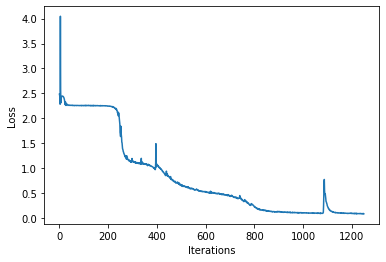

100%|██████████| 1250/1250 [1:55:45<00:00,  5.56s/it]


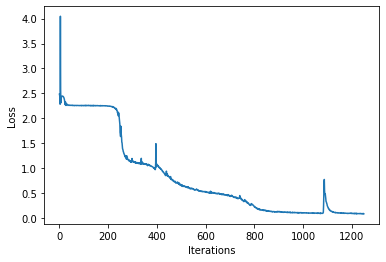

In [19]:
### Define optimizer and training operation ###

'''instantiate a new model for training using the `build_model`
  function and the hyperparameters created above.'''
model = build_model(vocabulary_size, embedding_dim, rnn_units, batch_size)
# model = build_model('''TODO: arguments''')

'''instantiate an optimizer with its learning rate.
  Checkout the tensorflow website for a list of supported optimizers.
  https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/
  Try using the Adam optimizer to start.'''
optimizer = tf.keras.optimizers.Adam(learning_rate)
# optimizer = # TODO

@tf.function
def train_step(x, y): 
  # Use tf.GradientTape()
  with tf.GradientTape() as tape:
  
    '''feed the current input into the model and generate predictions'''
    y_hat = model(x) # TODO
    # y_hat = model('''TODO''')
  
    '''compute the loss!'''
    loss = compute_loss(y, y_hat) # TODO
    # loss = compute_loss('''TODO''', '''TODO''')
    '''compute the accuracy!'''
    #accuracy=keras.metrics.accuracy(y, y_hat)

  # Now, compute the gradients 
  '''complete the function call for gradient computation. 
      Remember that we want the gradient of the loss with respect all 
      of the model parameters. 
      HINT: use `model.trainable_variables` to get a list of all model
      parameters.'''
  grads = tape.gradient(loss, model.trainable_variables) # TODO
  # grads = tape.gradient('''TODO''', '''TODO''')
  
  # Apply the gradients to the optimizer so it can update the model accordingly
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss

##################
# Begin training!#
##################

history = []
plotter = util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_training_iterations)):

  # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batch(vectorized_windows, seq_length, batch_size)
  loss = train_step(x_batch, y_batch)

  # Update the progress bar
  history.append(loss.numpy().mean())
  plotter.plot(history)

  # Update the model with the changed weights!
  if iter % 100 == 0:     
    model.save_weights(checkpoint_prefix)
    
# Save the trained model and the weights
model.save_weights(checkpoint_prefix)


## 4.6 Generate crime forecasted sequence

When generating future crime sequences, we'll have to feed the model some sort of seed to get it started (because it can't predict anything without something to start with!).

Once we have a generated seed, we can then iteratively predict each successive character using our trained RNN. 

More specifically, recall that our RNN outputs a `softmax` over possible successive characters. For inference, we iteratively sample from these distributions, and then use our samples to encode a generated crime sequence in a time series format or whatever the format of your training data.

### 4.6.1 Restore the latest checkpoint

To keep this inference step simple, we will use a batch size of 1. Because of how the RNN state is passed from timestep to timestep, the model will only be able to accept a fixed batch size once it is built. 

To run the model with a different `batch_size`, we'll need to rebuild the model and restore the weights from the latest checkpoint, i.e., the weights after the last checkpoint during training:

In [3]:
'''Rebuild the model using a batch_size=1'''
model = build_model(vocabulary_size, embedding_dim, rnn_units, batch_size=1) #Batch size will give you a better insight into the far future the bigger the value you set for batch size.

# Restore the model weights for the last checkpoint after training
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

model.summary()

NameError: ignored

Notice that we have fed in a fixed `batch_size` of 1 for inference.

### 4.6.2 The prediction procedure or loop

Now, we're ready to write the code to generate predictions:

* Initialize a "seed" start string and the RNN state, and set the number of characters we want to generate.

* Use the start string and the RNN state to obtain the probability distribution over the next predicted character.

* Sample from multinomial distribution to calculate the index of the predicted character. This predicted character is then used as the next input to the model.

* At each time step, the updated RNN state is fed back into the model, so that it now has more context in making the next prediction. After predicting the next character, the updated RNN states are again fed back into the model, which is how it learns sequence dependencies in the data, as it gets more information from the previous predictions.

![LSTM inference](https://raw.githubusercontent.com/aamini/introtodeeplearning/2019/lab1/img/lstm_inference.png)




It Starts by choosing a start string, initializing the RNN state and setting the number of characters to generate.

Get the prediction distribution of the next character using the start string and the RNN state.

Then, use a categorical distribution to calculate the index of the predicted character. Use this predicted character as our next input to the model.

The RNN state returned by the model is fed back into the model so that it now has more context, instead than only one character. After predicting the next character, the modified RNN states are again fed back into the model, which is how it learns as it gets more context from the previously predicted characters.


In [21]:
def generate_text(model, start_string, generation_length=1000):
  # Evaluation step (generating forecast using the trained RNN model)

  '''convert the start string to numbers (vectorize)'''
  input_eval = [char2idx[s] for s in start_string] 
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Here batch size == 1
  model.reset_states()
  tqdm._instances.clear()

  for i in tqdm(range(generation_length)):
      #evaluate the inputs and generate the next character predictions
      predictions = model(input_eval)

      # Remove the batch dimension
      predictions = tf.squeeze(predictions, 0)
      
      #Use a multinomial distribution to sample
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      # Pass the prediction along with the previous hidden state
      #   as the next inputs to the model
      input_eval = tf.expand_dims([predicted_id], 0)
      
      #Add the predicted character to the generated text
      #consider what format the prediction is in vs. the output
      text_generated.append(idx2char[predicted_id])
    
  return (start_string + ''.join(text_generated))

In [2]:
'''Use the model and the function defined above to generate a sequence in the input
 format text of length 1000!
'''
try:
  generated_text = generate_text(model, start_string="0.", generation_length=100000) 
except:
  print('Some error ocurred')  

Some error ocurred


### 4.6.3 Save predicted crime sequences.


In [ ]:
print(generated_text)

In [ ]:
save_to_path=os.path.join(path,'data','prediction','rnn_output.txt')
with open(save_to_path,mode='w') as file:
  file.write(generated_text)


In [ ]:
layers='3'
save_to_path=os.path.join(path,'data','prediction','rnn_output-'+str(batch_size)+'-'+str(seq_length)+'-'+
                          str(rnn_units)+'-'+str(layers)+'.txt')
with open(save_to_path,mode='w') as file:
  file.write(generated_text)


In [ ]:
#Avoid disconnect
import time

i=0
while True:
  time.sleep(60) 
  i+=1
  if i > 60:
    break